In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
from datetime import timedelta
register_matplotlib_converters()
import warnings
warnings.simplefilter("ignore")

In [2]:
"""
btc.arima_build(3,1,3)
plt.clf()

btc.arima_predict()
btc.stationarity(adf_test=False)"""
pass

In [2]:
class CurrencyAnalysis:
    def __init__(self,alpha,df_name,col,date_min,date_max,test_days=20,currency_name='',rolling_mean_window=12):
        self.alpha=alpha
        self.df_name=df_name
        self.col=col
        self.currency_name=currency_name
        self.model=None
        self.results=None
        self.date_min=date_min
        self.date_max=date_max
        self.date_test=date_max+timedelta(days=test_days)
        self.df=self.read_df()
        self.rwindow=rolling_mean_window
        self.test_days=test_days
        
    @staticmethod
    def init_figure():
        plt.gcf().set_size_inches(8,3.5)
    
    def _read_df(self,index='Date'):
        df1=pd.read_csv(self.df_name)
        df1[index]=df1[index].apply(pd.to_datetime)
        df1=df1[(df1[index]>=date_min) & (df1[index]<=date_max)]
        df1=df1.set_index(index)
        df1[self.col]=df1[self.col].astype(float)
        return df1
    
    def read_df(self,index='Date'):
        try:
            return self._read_df(index)
        except:
            return self.parse_data2([self.col])
        
    def parse_data2(self,cols):
        fname=self.df_name
        df=pd.read_excel(fname)
        df=df.iloc[1:237]
        df['Date']=df['data'].apply(pd.to_datetime)
        for x in cols:
            df[x]=df[x].astype(float)
        df['Open']=df[cols[0]]
        df=df[(df['Date']>=self.date_min) & (df['Date']<=self.date_max)]
        return df
    
    def _test(self,col='Open',index='Date',limits=None):
        df_test=pd.read_csv(self.df_name)
        df_test[index]=df_test[index].apply(pd.to_datetime)
        if limits is None:
            df_test=df_test[(df_test[index]>=self.date_max) & (df_test[index]<=self.date_test)]
        else:
            df_test=df_test[(df_test[index]>=limits[0]) & (df_test[index]<=limits[1])]
        df_test=df_test.set_index(index)
        df_test=df_test[self.col].astype(float)
        return df_test
    
    def test(self,col='Open',index='Date',limits=None):
        try:
            return self._test(col,index,limits)
        except:
            fname=self.df_name
            df=pd.read_excel(fname)
            df=df.iloc[1:237]
            df['Date']=df['data'].apply(pd.to_datetime)
            df[self.col]=df[self.col].astype(float)
            df['Open']=df[self.col]
            if limits is None:
                df=df[(df['Date']>=self.date_max) & (df['Date']<=self.date_test)]
            else:
                df=df[(df['Date']>=limits[0]) & (df['Date']<=limits[1])]
            
            return df['Open']
        
    
    def adf_test(self,df=None,col='Open'):
        if df is None:
            df=self.df[col]
        result = adfuller(df)
        print(col)
        print('ADF Statistic: {}'.format(result[0]))
        print('p-value: {}'.format(result[1]))
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t{}: {}'.format(key, value))
    
    def get_stationarity(self,timeseries,title=''):
        # rolling statistics
        rolling_mean = timeseries.rolling(window=self.rwindow).mean()
        rolling_std = timeseries.rolling(window=self.rwindow).std()
        # rolling statistics plot
        original = plt.plot(timeseries, color='blue', label='Original')
        mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
        std = plt.plot(rolling_std, color='black', label='Rolling Std')
        plt.legend(loc='best',prop={'size': 6})
        plt.title(title)
        plt.show(block=False)

        
    def stationarity(self,adf_test=True):
        self.init_figure()
        self.get_stationarity(self.df[self.col],self.currency_name)
        # Dickey–Fuller test:
        if adf_test:
            self.adf_test()
        
    def df_log_minus_mean(self,plot=True):
        df_log = self.df[self.col]
        rolling_mean = df_log.rolling(window=12).mean()
        df_log_minus_mean = df_log - rolling_mean
        df_log_minus_mean.dropna(inplace=True)
        if plot:
            self.init_figure()
            self.get_stationarity(df_log_minus_mean,self.currency_name)
            self.adf_test(df_log_minus_mean)
        return df_log_minus_mean
    
    def df_log_exp_decay(self,half_life,plot=True):
        df_log=self.df[self.col]
        rolling_mean_exp_decay = df_log.ewm(halflife=half_life, min_periods=0, adjust=True).mean()
        df_log_exp_decay = df_log - rolling_mean_exp_decay
        df_log_exp_decay.dropna(inplace=True)
        if plot:
            self.init_figure()
            self.get_stationarity(df_log_exp_decay,self.currency_name)
            self.adf_test(df_log_exp_decay)
        return df_log_exp_decay
    
    def df_log_shift(self,plot=True):
        df_log = self.df[self.col]
        df_log_shift = df_log - df_log.shift()
        df_log_shift.dropna(inplace=True)
        if plot:
            self.init_figure()
            self.get_stationarity(df_log_shift,self.currency_name)
            self.adf_test(df_log_shift)
        return df_log_shift
    
    def arima_build(self,p,d,q,plot=True,limits=None):
        plt.gcf().set_size_inches(4,2.5)
        plt.gca().axes.get_xaxis().set_visible(False)
        df_log=self.df[self.col]
        if limits is not None:
            df_log=df_log[limits[0]:limits[1]]
        #decomposition = seasonal_decompose(df_log)
        self.model = ARIMA(df_log, order=(p,d,q))
        self.results = self.model.fit()
        if plot:
            plt.plot(self.df_log_shift(plot=False))
            plt.plot(self.results.fittedvalues, color='red')
    
    def arima_predict(self,display_mae=True):
        results=self.results
        df_log=self.df[self.col]
        predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
        predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
        predictions_ARIMA_log = pd.Series(df_log.iloc[0], index=df_log.index)
        predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
        predictions_ARIMA = np.exp(predictions_ARIMA_log)
        #self.init_figure()
        actual=self.test('Open')
        #plt.show()
        predicted=results.predict(1,len(df_log)+self.test_days)
        if isinstance(predicted.index,pd.RangeIndex):
            predicted.index=predicted.index.map(int)
            actual.index=actual.index.map(int)
        predicted=predicted[len(df_log):(len(df_log)+len(actual))]
        plt.plot(predicted,label='Predicted')
        plt.plot(actual,label='Actual')
        if display_mae:
            self.calc_me(actual,predicted,skip=0)
            
    def predict_iter(self,model_params,window=30,delta=1,lim=np.inf):
        iter_date1=self.date_min
        iter_date2=self.date_min+timedelta(window)
        
        me_list=[]
        predicted_arr=[]
        actual_arr=[]
        i=-1
        while(iter_date2<self.date_max and i<lim-1):
            i+=1
            iter_date1+=timedelta(delta)
            iter_date2+=timedelta(delta)
            p,d,q=model_params
            self.arima_build(p,d,q,plot=False,limits=[iter_date1,iter_date2])
            actual=self.test('Open',limits=[iter_date2,iter_date2+timedelta(delta+1)])
            #print(iter_date2)
            
            if isinstance(actual.index,pd.DatetimeIndex):
                actual.index=list(range(len(actual.index)))
            
            if len(actual)==0:
                continue
            predicted=self.results.predict(0,actual.index[0]+delta+1)
            #print(predicted)
            
            #print(actual,predicted)
            #print(actual.index[0])
            #return actual,predicted
            if isinstance(actual.index,pd.RangeIndex):
                predicted.index=predicted.index.map(int)
                predicted=predicted[(actual.index[0]-1):(actual.index[0]+delta)]
                
            if len(predicted)==0 or len(actual)==0:
                print(iter_date1)
                print(iter_date2+timedelta(delta))
                continue
            try:
                me=self.calc_me(actual,predicted,skip=0,display=False)
                me_list.append(me)
            except:
                print("AAAA",actual,predicted)
                
            
            predicted_arr.append(predicted.mean())
            actual_arr.append(actual.mean())
        plt.clf()
        plt.plot(predicted_arr,label='Predicted',color='blue')
        plt.plot(actual_arr,label='Actual',color='orange')
        plt.legend()
        plt.show()
        return np.array(me_list)
            
            
            
    
    def calc_me(self,actual,predicted,skip=0,display=True):
        me=0
        skipped=0
        if isinstance(actual.index,pd.Int64Index):
            for i in actual.index:
                if skipped<skip:
                    skipped+=1
                    continue
                me+=(actual[i]-predicted[i])
        else:
            for i in range(len(actual)):
                if skipped<skip:
                    skipped+=1
                    continue
                me+=(actual[i]-predicted[i])  
        me/=len(actual-skipped)
        if display:
            print("The ME between the currency actual and predicted values is:",me)
        return me
    

In [15]:
alp=0.05
col='Open'

date_min=pd.to_datetime("2020.01.01")
date_max=pd.to_datetime("2020.06.01")
df_doge="coin_Dogecoin.csv"
df_btc="coin_Bitcoin.csv"
df_currencies="currencies.xls"
btc=CurrencyAnalysis(alp,df_btc,col,date_min,date_max,1,'BTC')

The ME between the currency actual and predicted values is: 0.0021402658500280962


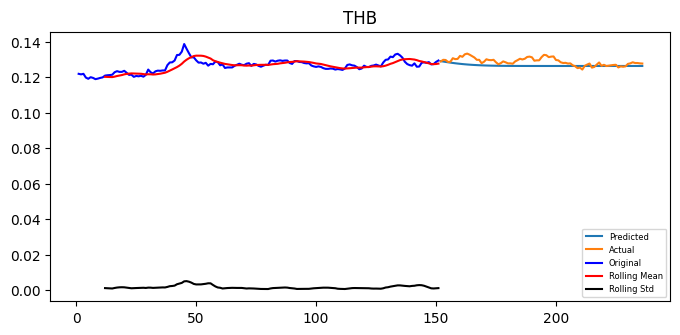

In [8]:
date_min=pd.to_datetime("2019.01.01")
date_max=pd.to_datetime("2022.08.07")
days=200
thb=CurrencyAnalysis(alp,df_currencies,'1 THB',date_min,date_max,days,'THB')

thb.arima_build(3,0,2)
plt.clf()

thb.arima_predict()
thb.stationarity(adf_test=False)

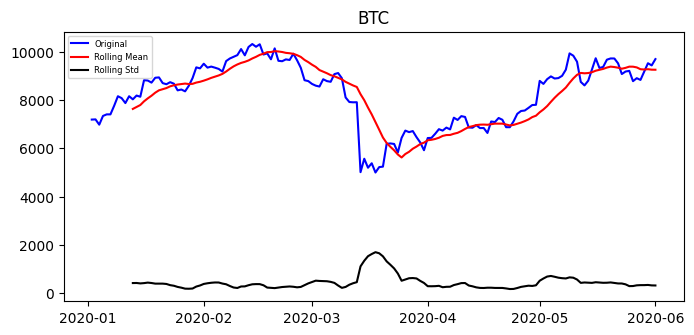

Open
ADF Statistic: -1.6295549202160473
p-value: 0.4677236944411852
Critical Values:
	1%: -3.4744158894942156
	5%: -2.880878382771059
	10%: -2.577081275821236


In [16]:
btc.stationarity(adf_test=True)

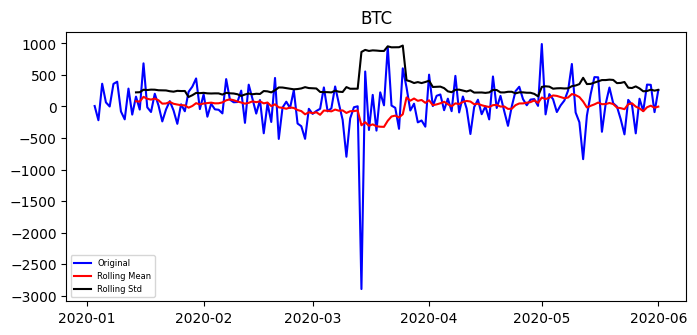

Open
ADF Statistic: -13.227982592734541
p-value: 9.713834997533754e-25
Critical Values:
	1%: -3.474714913481481
	5%: -2.881008708148148
	10%: -2.5771508444444446


Date
2020-01-02 23:59:59      7.659152
2020-01-03 23:59:59   -218.122510
2020-01-04 23:59:59    360.946663
2020-01-05 23:59:59     65.076418
2020-01-06 23:59:59      0.000474
                          ...    
2020-05-27 23:59:59    -72.204860
2020-05-28 23:59:59    347.563785
2020-05-29 23:59:59    343.410631
2020-05-30 23:59:59    -89.441620
2020-05-31 23:59:59    261.191688
Name: Open, Length: 151, dtype: float64

In [17]:
btc.df_log_shift()

In [18]:
#l=thb.predict_iter([3,0,2],window=50,delta=5,lim=3)

In [30]:
plt.show()

In [ ]:
l.mean()

In [ ]:
b

In [ ]:
date_min=pd.to_datetime("2021.01.01")
date_max=pd.to_datetime("2022.08.07")

thb=CurrencyAnalysis(alp,df_currencies,'1 THB',date_min,date_max,100,'THB')

In [ ]:
thb.arima_build(3,0,8)
plt.clf()

thb.arima_predict()
thb.stationarity(adf_test=False)

In [ ]:
thb.stationarity()

In [ ]:
btc.stationarity()

p-value > 0.05 => we conclude that the stationarity isn't present in the sample

Transform data:
(options)
1. subtract rolling mean
2. exponential decay
3. shift values & subtract
4. .

In [ ]:
"""
def parse_data2(cols):
    fname="currencies.xls"
    df=pd.read_excel(fname)
    df=df.iloc[1:237]
    df['data']=df['data'].apply(pd.to_datetime)
    df.set_index('data')
    for x in cols:
        df[x]=df[x].astype(float)
    return df
"""
pass

In [ ]:
btc.df_log_minus_mean()
plt.show()

In [ ]:
btc.df_log_exp_decay(half_life=12)
plt.show()

In [ ]:
btc.df_log_shift()
plt.show()

In [ ]:
btc.arima_build(2,1,2)

In [ ]:
btc.arima_predict(280)

In [ ]:
alp=0.05
col='Open'

date_min=pd.to_datetime("2020.01.01")
date_max=pd.to_datetime("2020.06.01")
date_test=pd.to_datetime("2020.07.01")

doge=CurrencyAnalysis(alp,df_doge,col,date_min,date_max,date_test,'Dogecoin')
#Doge isn't in trend
# => d: number of nonseasonal differences (differencing order) = 1
# p: number of autoregressive terms (AR order)
    
doge.arima_build(1,1,3)
plt.clf()
doge.arima_predict(174)